## Рекомендательные системы: предсказание оценки

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (1 балл)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
user_rate = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t')
user_rate['timestamp'] = pd.to_datetime(user_rate['timestamp'])

user_rate.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1970-01-01 00:19:22.160236
1,75,32,4.5,1970-01-01 00:19:22.160624
2,75,110,4.0,1970-01-01 00:19:22.161008
3,75,160,2.0,1970-01-01 00:19:22.160212
4,75,163,4.0,1970-01-01 00:19:22.160970


Выведим список id всех пользователей.

In [3]:
users = list(set(user_rate['userID']))
users.sort()

In [4]:
movies = list(set(user_rate.movieID))
movies.sort()

In [5]:
len(users)

2113

In [6]:
len(movies)

10109

Так мы можем получить нужные нам матрицы:

In [7]:
def create_samples(user_id, test, train, valid):
    user_info = user_rate[user_rate['userID'] == user_id].sort_values(by=['timestamp'])
    user_test = user_info[-5:]
    user_train = user_info[-10:-5]
    user_valid = user_info[:-10]
    
    test = test.append(user_test)
    train = train.append(user_train)
    valid = valid.append(user_valid)
    
    return test, train, valid

In [8]:
def add_missing_films(data):
    missing_films = set(movies) - set(data[data.userID == data.userID.iloc[0]].movieID)
    df_to_add = pd.DataFrame({'userID': np.ones(len(missing_films)) * data.userID.iloc[0], 'movieID': list(missing_films), 
                              'rating': np.zeros(len(missing_films)), 'timestamp': np.zeros(len(missing_films))}, 
                             columns=['userID', 'movieID', 'rating', 'timestamp'])
    df_to_add = df_to_add.astype(int)
    
    new_data = pd.concat([df_to_add, data])
    new_data = new_data.pivot(index='userID', columns='movieID', values='rating')
    new_data = new_data.fillna(0)
    new_data = sparse.csr_matrix(new_data)
    
    return(new_data)

In [9]:
test = pd.DataFrame()
train = pd.DataFrame()
valid = pd.DataFrame()

for user in users:
    test, train, valid = create_samples(user, test, train, valid)
    
test = add_missing_films(test)
train = add_missing_films(train)
valid = add_missing_films(valid)

In [10]:
test.shape, train.shape, valid.shape

((2113, 10109), (2113, 10109), (2113, 10109))

Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (2 балла)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [11]:
from scipy.stats import rankdata

In [12]:
def get_rank_mask(x, k):
    
    sorted_x = []
    
    for row in x:
        sorted_row = rankdata(row, method='ordinal')
        sorted_x.append(sorted_row.tolist())
        
    sorted_x = np.asarray(sorted_x)
    mask_x = (sorted_x > sorted_x.shape[1] - k)
    
    return sorted_x, mask_x

In [13]:
def rmse_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted

    sorted_true = np.zeros(y_true.shape[0] * y_true.shape[1]).reshape(y_true.shape[0], y_true.shape[1])
    sorted_predicted = np.zeros(y_true.shape[0] * y_true.shape[1]).reshape(y_true.shape[0], y_true.shape[1])
    
    _, sorted_mask = get_rank_mask(y_predicted, k)
    
    np.copyto(sorted_predicted, y_predicted_, where=sorted_mask)
    np.copyto(sorted_true, y_true_, where=sorted_mask)
    
    rmse = np.sqrt(np.power((sorted_true - sorted_predicted), 2).sum(axis = 1)/k).sum()/y_true_.shape[0]
    
    return rmse

def ndcg_score(y_true, y_predicted, k):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted
    
    sorted_true = np.zeros(y_true.shape[0] * y_true.shape[1]).reshape(y_true.shape[0], y_true.shape[1])
    sorted_predicted = np.zeros(y_true.shape[0] * y_true.shape[1]).reshape(y_true.shape[0], y_true.shape[1])
    ranks_masked = np.zeros(y_true.shape[0] * y_true.shape[1]).reshape(y_true.shape[0], y_true.shape[1])
    
    ranked_y_hat, sorted_mask = get_rank_mask(y_predicted, k)
    _, ranks_mask = get_rank_mask(ranked_y_hat, k)
    
    np.copyto(sorted_predicted, y_predicted_, where=sorted_mask)
    np.copyto(sorted_true, y_true_, where=sorted_mask)
    
    ranked_y_hat = -(ranked_y_hat - ranked_y_hat.shape[1] - 1)
    
    np.copyto(ranks_masked, ranked_y_hat, where=sorted_mask)
        
    g = np.power(2, sorted_true) - 1
    
    log2 = np.log2(ranks_masked) + 1
    np.place(log2, np.invert(sorted_mask), 0)
    d = np.divide(1, log2)
    np.place(d, np.invert(sorted_mask), 0)
    
    dcg = np.multiply(g, d)
    
    max_dcg = dcg.max(axis = 1)
    max_dcg = np.repeat(max_dcg, sorted_true.shape[1], axis=0).reshape(sorted_true.shape[0], sorted_true.shape[1])
    
    div = np.divide(dcg, max_dcg)
    np.nan_to_num(div, copy=False)

    ndcg = div.sum()/sorted_true.shape[0]
    
    return ndcg

**3. (1 балл)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

Поскольку в этом методе у нас нет гиперпараметров, мы можем обучать и на тренировочной, и на валидационной выборках.

Чтобы посчитать среднюю оценку для каждого оцененного пользователя, получим маску матрицы тренировочной выборки и посчитаем среднее через эту маску. 

In [384]:
train_dense = train.todense()
train_mask = np.invert(train_dense != 0)

train_masked = np.ma.array(train_dense, mask=train_mask).mean(axis = 0)

In [388]:
means = np.array(train_masked)
most_pop = np.repeat(means[None], 2113, axis=0).reshape(2113, 10109)

In [313]:
rmse_score(y_true = test, y_predicted = most_pop, k = 5)

4.998821339048528

In [314]:
ndcg_score(y_true = test, y_predicted = most_pop, k = 5)

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


0.00236630383341221

**4. (1 балл)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [355]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [336]:
def compute_svd(matrix, n_components):
    svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=1).fit(matrix)
    y_hat = svd.inverse_transform(svd.transform(matrix))
    return y_hat

In [397]:
num_eig = np.linspace(1, 100, 5)
num_eig = num_eig.astype(int)

In [398]:
rmses = []
ndcgs = []

for eig in num_eig:
    y_hat = compute_svd(valid, eig)
    rmses.append(rmse_score(y_true = test, y_predicted = y_hat, k = 5))
    ndcgs.append(ndcg_score(y_true = test, y_predicted = y_hat, k = 5))

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


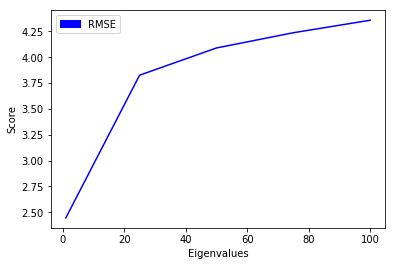

In [399]:
plt.plot(num_eig, rmses, c = 'b', label = 'RMSE')
plt.xlabel('Eigenvalues')
plt.ylabel('Score')
blue_patch = mpatches.Patch(color='blue', label='RMSE')
plt.legend(handles=[blue_patch])
plt.show()

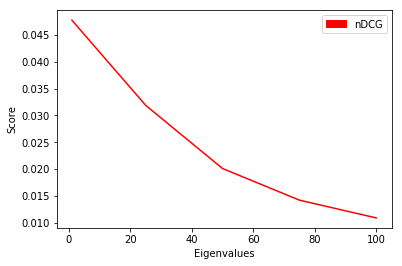

In [400]:
plt.plot(num_eig, ndcgs, c = 'r', label = 'nDCG')
plt.xlabel('Eigenvalues')
plt.ylabel('Score')
red_patch = mpatches.Patch(color='red', label='nDCG')
plt.legend(handles=[red_patch])
plt.show()

In [14]:
%%bash
say finished

**5. (3 балла)** Постройте рекомендации на основе user-based коллаборативной фильтрации. 
Предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. 

Значение параметра $\alpha$ возьмите равным 0.9.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке.

In [25]:
def similarity(i, j, data):
    
    if i == j:
        return 1
    
    user_i = data[i,:]
    user_j = data[j,:]
    
    i_bool = (data[i,:] != 0)
    j_bool = (data[j,:] != 0)
    
    intersection_bool = np.logical_and(i_bool, j_bool)
    
    if (intersection_bool.sum() == 0) | (intersection_bool.sum() == 1) | (intersection_bool.size == 0):
        return 0
    
    intersection = np.where(intersection_bool == True)
    
    i_ratings = np.array([user_i[loc] for loc in intersection])
    j_ratings = np.array([user_j[loc] for loc in intersection])
    
    return np.corrcoef(i_ratings, j_ratings)[0,1]

In [36]:
valid_dense = np.array(valid.todense())

In [38]:
corr = []

for i in range(valid_dense.shape[0]):
    row = []
    for j in range(valid_dense.shape[0]):
        row.append(similarity(i, j, valid_dense))
    corr.append(row)

corr = np.array(corr)

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [105]:
%%bash
say finished

In [49]:
ALPHA = 0.9

In [78]:
a, b = np.where(corr > ALPHA)

pairs = []

for i in range(len(users)):
    user = []
    for j in range(len(a)):
        if users[i] == a[j]:
            user.append(b[j])
    pairs.append(user)

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [80]:
pairs = []

for i in range(len(users)):
    other_users = corr[i,:]
    paired = np.where(other_users > ALPHA)
    pairs.append(paired[0])

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [101]:
avg_rating = valid.todense()
valid_mask = np.invert(avg_rating != 0)

avg_rating = np.ma.array(avg_rating, mask=valid_mask).mean(axis = 0)
avg_rating = np.array(avg_rating).flatten()

In [104]:
train_dense = np.array(train.todense())

col_fil = np.zeros((test.shape[0], test.shape[1]))

for u in range(len(users)):
    for i in range(len(movies)):
        U = pairs[u]
        
        weighted_sum = 0
        weights_sum  = 0
        
        for v in U:
            weighted_sum += corr[u, v] * (train_dense[v, i] - avg_rating[v])
            weights_sum += corr[u, v]
                
        
        col_fil[u, i] = avg_rating[u] + weighted_sum / weights_sum

In [106]:
rmse_score(y_true = test, y_predicted = col_fil, k = 5)

0.7839627991401198

In [107]:
ndcg_score(y_true = test, y_predicted = col_fil, k = 5)

/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/Users/andrey_lukyanov/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


0.026359633109582264

**6. (1 балл)** Какой метод оказался лучше по каким метрикам? Почему?

Самым лучшим оказался SVD с количеством небольшим количеством компонент (до 5). Скорее всего, большее число компонент приводит к тому, что матрица оценок становится более разряженной. Если подставлять в метрики разряженные матрицы, то меньше вероятности найти пересечения множества фильмов у пользователей. В случае низкого количество пересечений, очевидно, метрики будут низкими.

Самым худшим оказался метод most popular, так как у него самые низкие значения по метрикам.

Коллаборативная фильтрация показала себя лучше most popular, но хуже SVD.

**7. (1 балл)** Приведите достоинства и недостатки используемых метрик. Какие еще метрики можно было бы использовать для решения задачи? Приведите примеры других постановок задачи, как в этом случае можно было бы оценить качество?

Достоинством nDCG является то, что она учитывает ранжирование. В RMSE такого нет, что является ее главным недостатком.

Можно было использовать, например, F-меру, prescision, recall. 

Если бы мы могли также учитывать данные по количеству визитов пользователей на сайт, можно было бы использовать в качестве метрики, например, частоту визитов пользователей.